In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [2]:
df_news = pd.read_csv("../data/apple_2023/news_apple_2023.csv", index_col=0)
df_price = pd.read_csv("../data/apple_2023/price_apple_2023.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2023-01-01 00:19:34  Title: iPhone 15 release date speculation: Her...
1 2023-01-01 01:25:56  Title: Apple (NASDAQ:AAPL) PT Set at $184.00 b...
2 2023-01-01 01:32:30  Title: 2023 Dividend Growth Portfolio Review A...
3 2023-01-01 02:52:26  Title: Tracking Terry Smith's Fundsmith 13F Po...
4 2023-01-01 03:10:16  Title: 5 appliances and smart home gadgets tha...
                 date       price
0 2023-01-03 09:31:00  129.058631
1 2023-01-03 09:32:00  128.929353
2 2023-01-03 09:33:00  128.740410
3 2023-01-03 09:34:00  129.307241
4 2023-01-03 09:35:00  129.108353


In [3]:
dfs = []
for i in range(1, 6):
    df_score = pd.read_csv(f"../data/apple_2023/news_score_apple_2023_{i}.csv", index_col=0)
    print(df_score.shape)
    df_score = df_score[["date", "score"]]
    df_score["date"] = pd.to_datetime(df_score['date'])
    dfs.append(df_score)
    
df_score = pd.concat(dfs)
df_score.reset_index(drop = True, inplace = True)
df_score.to_csv("../data/apple_2023/news_score_apple_2023_all.csv")
df_score


# df_score = pd.read_csv(f"../data/apple_2023/news_score_apple_2023_{1}.csv", index_col=0)
# print(df_score.shape)
# df_score = df_score[["date", "score"]]
# df_score["date"] = pd.to_datetime(df_score['date'])

(2000, 3)
(1320, 3)
(332, 3)
(332, 3)
(1480, 3)


,date,score
0,2023-01-01 00:19:34,1
1,2023-01-01 05:54:24,1
2,2023-01-01 14:20:37,0
3,2023-01-02 05:08:21,1
4,2023-01-02 09:50:11,1
...,...,...
5459,2023-05-19 08:11:33,-1
5460,2023-05-19 09:38:21,1
5461,2023-05-19 10:51:25,1
5462,2023-05-19 11:41:26,1


In [4]:
df_score = df_score.sort_values("date")
df_score.reset_index(drop = True, inplace = True)
df_score

,date,score
0,2023-01-01 00:19:34,1
1,2023-01-01 01:25:56,1
2,2023-01-01 01:32:30,1
3,2023-01-01 02:52:26,-1
4,2023-01-01 03:10:16,1
...,...,...
5459,2023-11-29 14:47:43,-1
5460,2023-11-30 10:50:15,0
5461,2023-11-30 10:59:20,1
5462,2023-12-01 11:02:32,0


In [5]:
df_score["score"].value_counts()

 1    2980
 0    1498
-1     986
Name: score, dtype: int64

In [6]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [7]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [8]:
df_news.shape

(33152, 2)

In [9]:

columns = [f"price_in_{i}" for i in range(61)]
deltas = [i for i in range(61)]
pd_price = np.zeros((df_news.shape[0], 61))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(61):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [10]:
date_price_dict

{Timestamp('2023-01-03 09:31:00'): 129.058630848,
 Timestamp('2023-01-03 09:32:00'): 128.92935344,
 Timestamp('2023-01-03 09:33:00'): 128.740409536,
 Timestamp('2023-01-03 09:34:00'): 129.307241248,
 Timestamp('2023-01-03 09:35:00'): 129.108352928,
 Timestamp('2023-01-03 09:36:00'): 129.168019424,
 Timestamp('2023-01-03 09:37:00'): 128.864714736,
 Timestamp('2023-01-03 09:38:00'): 129.32713008,
 Timestamp('2023-01-03 09:39:00'): 129.317185664,
 Timestamp('2023-01-03 09:40:00'): 129.7746288,
 Timestamp('2023-01-03 09:41:00'): 129.764684384,
 Timestamp('2023-01-03 09:42:00'): 130.013294784,
 Timestamp('2023-01-03 09:43:00'): 129.754739968,
 Timestamp('2023-01-03 09:44:00'): 129.754739968,
 Timestamp('2023-01-03 09:45:00'): 129.168019424,
 Timestamp('2023-01-03 09:46:00'): 128.969131104,
 Timestamp('2023-01-03 09:47:00'): 129.098408512,
 Timestamp('2023-01-03 09:48:00'): 128.55643784,
 Timestamp('2023-01-03 09:49:00'): 127.924967424,
 Timestamp('2023-01-03 09:50:00'): 127.875245344,
 Time

In [11]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [12]:
result_df

,date,news,price_in_0,price_in_1,price_in_2,price_in_3,price_in_4,price_in_5,price_in_6,price_in_7,...,price_in_51,price_in_52,price_in_53,price_in_54,price_in_55,price_in_56,price_in_57,price_in_58,price_in_59,price_in_60
0,2023-01-01 00:19:34,Title: iPhone 15 release date speculation: Her...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-01-01 01:25:56,Title: Apple (NASDAQ:AAPL) PT Set at $184.00 b...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-01-01 01:32:30,Title: 2023 Dividend Growth Portfolio Review A...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-01-01 02:52:26,Title: Tracking Terry Smith's Fundsmith 13F Po...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-01-01 03:10:16,Title: 5 appliances and smart home gadgets tha...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33147,2023-12-01 23:33:29,Title: Garcia vs Duarte live stream: How to wa...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33148,2023-12-01 23:33:31,Title: iPhone 16 Pro could be getting the 15 P...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33149,2023-12-01 23:33:37,Title: Act fast! The MacBook Air M2 is on sale...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33150,2023-12-01 23:33:54,Title: Samsung Galaxy S24 Ultra leak just reve...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_score

,date,score
0,2023-01-01 00:19:34,1
1,2023-01-01 01:25:56,1
2,2023-01-01 01:32:30,1
3,2023-01-01 02:52:26,-1
4,2023-01-01 03:10:16,1
...,...,...
5459,2023-11-29 14:47:43,-1
5460,2023-11-30 10:50:15,0
5461,2023-11-30 10:59:20,1
5462,2023-12-01 11:02:32,0


In [14]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = [f"return_in_{i}" for i in range(1,61)]
price_cols = [f"price_in_{i}" for i in range(61)]

for i in range(60):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_in_0"]) / result_df["price_in_0"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df = result_df.dropna()
result_df

,date,news,score,return_in_1,return_in_2,return_in_3,return_in_4,return_in_5,return_in_6,return_in_7,...,return_in_51,return_in_52,return_in_53,return_in_54,return_in_55,return_in_56,return_in_57,return_in_58,return_in_59,return_in_60
110,2023-01-03 09:42:30,Title: Apple’s Magic Keyboard for 12.9-inch M2...,1.0,0.0,0.000000,-0.004522,-0.006055,-0.005058,-0.009235,-0.014102,...,-0.038933,-0.040696,-0.040466,-0.041002,-0.041309,-0.040466,-0.039201,-0.039010,-0.036711,-0.036097
111,2023-01-03 09:43:27,Title: Thinking about trading options or stock...,1.0,0.0,-0.004522,-0.006055,-0.005058,-0.009235,-0.014102,-0.014485,...,-0.040696,-0.040466,-0.041002,-0.041309,-0.040466,-0.039201,-0.039010,-0.036711,-0.036097,-0.036787
114,2023-01-03 10:01:29,Title: What’s Ahead for Wall Street in 2023?. ...,0.0,0.0,-0.001338,-0.001575,-0.004015,-0.001338,-0.003464,-0.002441,...,-0.014014,-0.012203,-0.012911,-0.013462,-0.012360,-0.012754,-0.012045,-0.011770,-0.011219,-0.009447
120,2023-01-03 10:48:17,Title: Elon Musk Expresses Dissatisfaction Ove...,-1.0,0.0,0.000478,-0.001154,-0.003025,-0.001194,-0.001911,-0.002468,...,-0.003582,-0.003025,-0.002468,-0.003184,-0.004219,-0.004537,-0.005254,-0.005413,-0.006687,-0.006607
121,2023-01-03 10:57:28,Title: The next Apple Pencil might be able to ...,1.0,0.0,0.000279,0.000837,0.002630,0.001753,0.001753,0.001594,...,-0.005578,-0.005817,-0.005100,-0.005897,-0.006176,-0.005419,-0.007570,-0.007252,-0.007331,-0.007212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32927,2023-11-29 14:47:43,Title: What's Going On With Apple Stock?. Desc...,-1.0,0.0,0.000106,0.000132,0.000344,0.000159,0.000053,0.000106,...,-0.000344,-0.000449,-0.000079,0.000053,0.000766,0.000449,0.000555,0.001004,0.001004,0.000978
33026,2023-11-30 10:50:15,"Title: Getting Closer: The Bloomberg Close, Eu...",0.0,0.0,0.000371,-0.000504,-0.000637,-0.000530,-0.000477,-0.000159,...,-0.000796,-0.000743,-0.001008,-0.001406,-0.000849,-0.001220,-0.001220,-0.001379,-0.000637,-0.000690
33027,2023-11-30 10:59:20,Title: New app brings power of video to job ca...,1.0,0.0,0.000530,0.000795,0.000371,-0.000159,-0.000477,-0.000636,...,-0.001960,-0.002013,-0.001854,-0.002331,-0.002278,-0.002278,-0.002278,-0.002702,-0.002861,-0.002702
33126,2023-12-01 11:02:32,Title: Get A $200 Pair Of Sennheiser Noise-Can...,0.0,0.0,0.000026,0.000236,-0.000603,-0.000865,-0.000498,0.000131,...,0.001652,0.002701,0.002386,0.002386,0.002334,0.002334,0.002281,0.001967,0.002019,0.002124


In [15]:
result_df = result_df.dropna()

In [16]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_48147/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,score,return_in_1,return_in_2,return_in_3,return_in_4,return_in_5,return_in_6,return_in_7,...,return_in_51,return_in_52,return_in_53,return_in_54,return_in_55,return_in_56,return_in_57,return_in_58,return_in_59,return_in_60
count,1498,1498,1498.000000,1498.0,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,...,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000
unique,1487,1480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2023-03-23 12:16:31,Title: Check Out What Whales Are Doing With AA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2023-01-03 09:42:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-12-01 11:08:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.455941,0.0,0.000002,-0.000010,0.000019,0.000032,0.000042,0.000038,...,0.000114,0.000115,0.000112,0.000107,0.000101,0.000109,0.000139,0.000144,0.000122,0.000128
std,NaN,NaN,0.735398,0.0,0.000704,0.000984,0.001213,0.001377,0.001590,0.001802,...,0.004659,0.004696,0.004727,0.004744,0.004766,0.004787,0.004780,0.004747,0.004746,0.004778
min,NaN,NaN,-1.000000,0.0,-0.004522,-0.006055,-0.007152,-0.010210,-0.014102,-0.014485,...,-0.040696,-0.040696,-0.041002,-0.041309,-0.041309,-0.040466,-0.039201,-0.039010,-0.036711,-0.036787
25%,NaN,NaN,0.000000,0.0,-0.000331,-0.000488,-0.000586,-0.000606,-0.000700,-0.000818,...,-0.002020,-0.002088,-0.002071,-0.002172,-0.002239,-0.002210,-0.002226,-0.002187,-0.002293,-0.002333


In [17]:
result_df[result_df['score'] == i][f"return_in_{j}"].mean()

nan

In [18]:
# import seaborn as sns
# for return_col in ['return_in_5', 'return_in_10', 'return_in_20', 'return_in_60']:
#     sns.scatterplot(x='score', y=return_col, data=result_df, alpha=0.1)
#     plt.title(f'Score vs {return_col}')
#     plt.show()

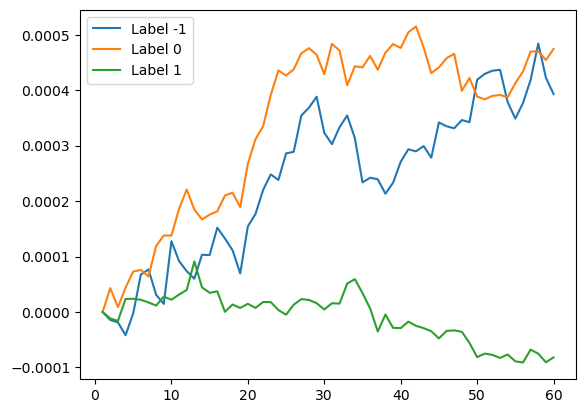

In [19]:
import matplotlib.pyplot as plt
for i in [-1, 0, 1]:
    arr = []
    for j in range(1, 61):
        avg_return = result_df[result_df['score'] == i][f"return_in_{j}"].mean()
        arr.append(avg_return)
    plt.plot(list(range(1,61)), arr, label=f'Label {i}')

plt.legend()
plt.show()
    

In [20]:

for j in [-1, 0, 1]:
    print(f"When score is {j}, the mean return is {result_df[result_df['score'] == j]['return_in_60'].mean()*10000}")
    

When score is -1, the mean return is 3.9301024245816207
When score is 0, the mean return is 4.743130023568113
When score is 1, the mean return is -0.8185996526419516
